## Aggregate Health Statistics on UKHLS dataset

#### March 22nd by Gavin Qu

In [1]:
import pandas as pd
import numpy as np
import pyreadstat

In [3]:
# use latin-1 encoding if UTF8 does not work
wave1, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/a_indresp.dta")
wave2, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/b_indresp.dta")
wave3, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/c_indresp.dta", encoding="iso-8859-1")
wave4, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/d_indresp.dta")
wave5, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/e_indresp.dta", encoding="iso-8859-1")
wave6, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/f_indresp.dta")
wave7, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/g_indresp.dta")
wave8, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/h_indresp.dta")
wave9, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/i_indresp.dta")
wave10, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/j_indresp.dta")
wave11, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/k_indresp.dta")
wave12, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/l_indresp.dta")
wave13, meta = pyreadstat.read_dta("/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/m_indresp.dta")

#### Read into the Pandas framework

In [4]:
df1 = pd.DataFrame(wave1)
df2 = pd.DataFrame(wave2)
df3 = pd.DataFrame(wave3)
df4 = pd.DataFrame(wave4)
df5 = pd.DataFrame(wave5)
df6 = pd.DataFrame(wave6)
df7 = pd.DataFrame(wave7)
df8 = pd.DataFrame(wave8)
df9 = pd.DataFrame(wave9)
df10 = pd.DataFrame(wave10)
df11 = pd.DataFrame(wave11)
df12 = pd.DataFrame(wave12)
df13 = pd.DataFrame(wave13)

#### Clean the data before combining

In [33]:
waves = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
prefixes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']

for wave, prefix in zip(waves, prefixes):
    wave[f'{prefix}_lf_stat'] = None # generate the lf variable

    # Conditions should be based on 'jbstat' column
    employed_conditions = wave[f'{prefix}_jbstat'].isin([1, 2, 5, 9, 10, 11, 12, 13])
    unemployed_condition = wave[f'{prefix}_jbstat'] == 3
    inactive_conditions = wave[f'{prefix}_jbstat'].isin([4, 6, 7, 8])

    # Set lf_stat based on these conditions
    wave.loc[employed_conditions, f'{prefix}_lf_stat'] = 1
    wave.loc[unemployed_condition, f'{prefix}_lf_stat'] = 2
    wave.loc[inactive_conditions, f'{prefix}_lf_stat'] = 3

    wave[f'{prefix}_changejbstat'] = None # generate the changejbstat variable

    # check if this wave includes the empchk variable
    if f'{prefix}_empchk' in wave.columns and f'{prefix}_notempchk' in wave.columns:
        wave[f'{prefix}_changejbstat'] = None  # initialize the changejbstat variable

        # conditions for previous employment
        condition_0 = (wave[f'{prefix}_empchk'] == 1) | (wave[f'{prefix}_notempchk'] == 1)
        condition_1 = (wave[f'{prefix}_empchk'] == 2) | (wave[f'{prefix}_notempchk'] == 2)

        # assign values based on conditions
        wave.loc[condition_0, f'{prefix}_changejbstat'] = 0
        wave.loc[condition_1, f'{prefix}_changejbstat'] = 1
    else:
        print(f"'empchk' and 'notempchk' variables not found in wave {prefix}")

    # create dummy for private sector
    wave[f'{prefix}_private'] = np.nan
    wave.loc[wave[f'{prefix}_jbsect'] == 1, f'{prefix}_private'] = 1 # 1 for private
    wave.loc[wave[f'{prefix}_jbsect'] == 2, f'{prefix}_private'] = 0 # 2 for other types

    # replace missing values in pay variables
    pay_vars = [f'{prefix}_paygu_dv', f'{prefix}_paynu_dv']
    for var in pay_vars:
        wave[var].replace(list(range(-9, 0)), np.nan, inplace=True)

    # convert to hourly pay
    wave[f'{prefix}_hrgpay'] = wave[f'{prefix}_paygu_dv'] / (4.333 * 40)
    wave[f'{prefix}_hrnpay'] = wave[f'{prefix}_paynu_dv'] / (4.333 * 40)

    # log hourly pay (only for non-zero values)
    wave[f'{prefix}_logpay'] = np.log(wave.loc[wave[f'{prefix}_hrgpay'] > 0, f'{prefix}_hrgpay'])

    # earnings
    wave[f'{prefix}_earnings'] = wave[f'{prefix}_paygu_dv']
    wave.loc[wave[f'{prefix}_jbhrs'] <= 0, f'{prefix}_earnings'] = np.nan

    # create education categories
    education_mapping = {1: 1, 2: 1, 3: 2, 4: 3, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4}
    wave[f'{prefix}_education'] = wave[f'{prefix}_hiqual_dv'].map(education_mapping)

    # create aggregate health variable where 1 is unhealthy, 2 is healthy
    wave[f'{prefix}_agghealth'] = wave[f'{prefix}_health'].map({1: 1, 2: 2})

'empchk' and 'notempchk' variables not found in wave a


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_92391/2184062997.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wave[var].replace(list(range(-9, 0)), np.nan, inplace=True)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_92391/2184062997.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

#### Combine data with the relevant variables

In [34]:
import pandas as pd

waves = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
prefixes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']

# define the columns to keep after removing prefixes
columns_to_keep = ['lf_stat', 'changejbstat', 'private', 'hrgpay', 'hrnpay', 'logpay', 'earnings', 'education', 'agghealth', 'pidp', 'wave']

long_panel_data = pd.DataFrame()

for wave, prefix in zip(waves, prefixes):
    wave['wave'] = prefix  # add a 'wave' column to each DataFrame

    # remove the prefix from column names and retain only relevant columns
    wave = wave.rename(columns={f'{prefix}_{col}': col for col in columns_to_keep if f'{prefix}_{col}' in wave.columns})
    wave = wave[columns_to_keep]

    # append to the long panel data DataFrame
    long_panel_data = pd.concat([long_panel_data, wave])

# sort by 'pidp' and 'wave'
long_panel_data.sort_values(by=['pidp', 'wave'], inplace=True)

# reset index
long_panel_data.reset_index(drop=True, inplace=True)

# Convert columns with object dtype to string, and fill NaNs with a placeholder if necessary
for col in long_panel_data.select_dtypes(include=['object']).columns:
    long_panel_data[col] = long_panel_data[col].fillna('NA').astype(str)

# Check for any columns that contain only NaNs and handle them
for col in long_panel_data.columns:
    if long_panel_data[col].isna().all():
        long_panel_data[col] = long_panel_data[col].fillna('Missing')

# Now try saving to a Stata file again
long_panel_data.to_stata("combined_panel_data.dta")


In [35]:
result = pd.read_stata('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/combined_panel_data.dta')

result

,index,lf_stat,changejbstat,private,hrgpay,hrnpay,logpay,earnings,education,agghealth,pidp,wave
0,0,1,NA,0.0,6.923610,5.192707,1.934937,1200.000000,2.0,2.0,22445,d
1,1,1,0,0.0,9.037906,7.500577,2.201428,1566.449951,2.0,2.0,22445,e
2,2,1,0,0.0,14.323737,11.193169,2.661918,2482.590088,2.0,2.0,22445,f
3,3,1,0,0.0,16.251269,10.385414,2.788171,2816.669922,2.0,2.0,22445,g
4,4,1,0,0.0,16.732056,11.539349,2.817326,2900.000000,2.0,2.0,22445,h
...,...,...,...,...,...,...,...,...,...,...,...,...
533471,533471,1,NA,1.0,25.904050,18.372375,3.254399,4489.689941,NaN,2.0,1653277290,f
533472,533472,1,0,1.0,24.040330,23.078698,3.179733,4166.669922,NaN,2.0,1653277290,g
533473,533473,1,0,1.0,28.866778,19.615682,3.362691,5003.189941,NaN,2.0,1653277290,h
533474,533474,1,NA,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1653277290,i


In [36]:
# double check if combined data set is correct in rows
wave_row_counts = [50994, 54569, 49692, 47074, 44837, 45192, 42170, 39294, 36058, 34319, 32008, 29271, 27998]
expected_total_rows = sum(wave_row_counts)
expected_total_rows

533476

## Data Analysis

### Construct the aggregate health variable as a histogram
#### 1 for answering yes and 2 for answering no to the new health problem question

In [37]:
import matplotlib.pyplot as plt

In [ ]:
long_panel_data = pd.read_stata('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/combined_panel_data.dta')

# percentage of people with newly developed health issues
health_percentage_by_wave = long_panel_data.groupby('wave')['agghealth'].apply(lambda x: (x == 1).mean() * 100)

plt.figure(figsize=(10, 6))
health_percentage_by_wave.plot(kind='bar', color='skyblue')
plt.title('Percentage of People with Newly Developed Health Problems by Wave')
plt.xlabel('Wave')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=30)
plt.show()

#### Here's a summary of the labor force

In [ ]:
print(long_panel_data['lf_stat'].head())

# check the unique values and their counts in the 'lf_stat' column
print(long_panel_data['lf_stat'].value_counts())

counts = long_panel_data['lf_stat'].astype(str).value_counts()
for val in ['1', '2', '3']:
    print(f"Count of '{val}' in lf_stat: {counts.get(val, 0)}")

- Employed (1): 296,237 instances.
- Unemployed (2): 25,886 instances.
- Inactive (3): 207,761 instances.
- Not Available/Classified (NA): 3,592 instances.

### Descriptive Statistics

In [43]:
print("Frequencies for lf_stat:")
print(long_panel_data['lf_stat'].value_counts())

print("\nFrequencies for agghealth:")
print(long_panel_data['agghealth'].value_counts())

print("\nFrequencies for changejbstat:")
print(long_panel_data['changejbstat'].value_counts())

if long_panel_data['changejbstat'].dtype in ['int64', 'float64']:
    print("\nDescriptive Statistics for changejbstat:")
    print(long_panel_data['changejbstat'].describe())

Frequencies for lf_stat:
lf_stat
1     296237
3     207761
2      25886
NA      3592
Name: count, dtype: int64

Frequencies for agghealth:
agghealth
2.0    349247
1.0    183126
Name: count, dtype: int64

Frequencies for changejbstat:
changejbstat
0     385080
NA    104974
1      43422
Name: count, dtype: int64


### Examine Distribution

#### Given the nature of the categorical data, I will use histograms and boxplot for this

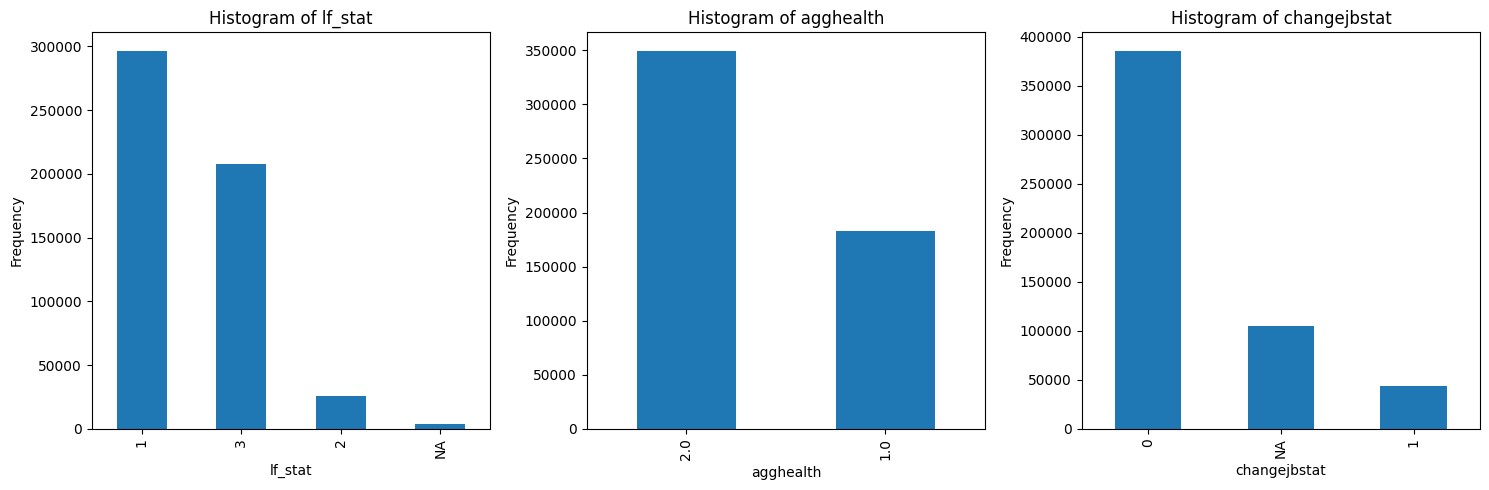

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# histogram for lf_stat
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
long_panel_data['lf_stat'].value_counts().plot(kind='bar')
plt.title('Histogram of lf_stat')
plt.xlabel('lf_stat')
plt.ylabel('Frequency')

# histogram for agghealth
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
long_panel_data['agghealth'].value_counts().plot(kind='bar')
plt.title('Histogram of agghealth')
plt.xlabel('agghealth')
plt.ylabel('Frequency')

# histogram for changejbstat
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
long_panel_data['changejbstat'].value_counts().plot(kind='bar')
plt.title('Histogram of changejbstat')
plt.xlabel('changejbstat')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

#### Cross-tabulation, or creating a contingency table, will help us see how the distribution of health conditions varies across different employment statuses.

In [47]:
import pandas as pd

# cross-tabulation of agghealth and lf_stat
crosstab = pd.crosstab(long_panel_data['agghealth'], long_panel_data['lf_stat'])

print("Cross-tabulation of agghealth and lf_stat:")
print(crosstab)

# get proportions instead of counts
crosstab_normalized = pd.crosstab(long_panel_data['agghealth'], long_panel_data['lf_stat'], normalize='index') * 100

print("\nProportions of agghealth across lf_stat:")
print(crosstab_normalized)

Cross-tabulation of agghealth and lf_stat:
lf_stat         1      2       3    NA
agghealth                             
1.0         69318   9098  103526  1184
2.0        226499  16683  103853  2212

Proportions of agghealth across lf_stat:
lf_stat            1         2          3        NA
agghealth                                          
1.0        37.852626  4.968164  56.532661  0.646549
2.0        64.853528  4.776848  29.736261  0.633363
